## Reinforcement Learning: Homework 1
### Juan Felipe Godoy

First of all I am going to define the elements of the MDP: action set, state set and transition function.

In [1]:
# Initial set up
import numpy as np
import matplotlib.pyplot as plt
import timeit

In [2]:
# Properties of the MDP
N = 100 # Number of states
q_low = 0.51 #probability of action_low
q_high = 0.6 #probability of action_high
c_low = 0 #cost of action low
c_high = 0.01 #cost of action high
p = 0.5 #arrival rate
gamma=0.9 # discount factor


In the cells below, I define two matrices containing the probability of occurrence for each possible state. I build one matrix for action = low and one for action = high.

In both matrices there are two special cases in which the probabilities are different in comparison to the other values:  transition from $x_t = 0$ to $x_{t+1}=-1$ and from $x_t = 99$ to $x_{t+1}=100$. The queue length is updated following a "trunc" operator that truncates the interval to $[0, N-1]$, so probabilities in the upper left and lower right corners change. For example, it is impossible to be in state  $x_t = 0$ and take any action that decreases the queue in one person. Then, in both cases I incremented the probability in the diagonal I.e. not changing state. 

In [3]:
# Transition matrices 

# Action high

m_high = np.zeros(shape=(N,N))
np.fill_diagonal(m_high,(p*q_high)+(1-p)*(1-q_high))

# right
for i in range(N-1):
    if i != N-1:
        m_high[i][i+1]=p*(1-q_high)
    if i == 0:
        m_high[i][i+1]=0.2
        m_high[i][i]=0.8

# Left
for i in range(N):
    if i != 0:
        m_high[i][i-1]=(1-p)*(q_high)
    if i == N-1:
        m_high[i][i-1]=0.3
        m_high[i][i]=0.7

print(m_high)


[[0.8 0.2 0.  ... 0.  0.  0. ]
 [0.3 0.5 0.2 ... 0.  0.  0. ]
 [0.  0.3 0.5 ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 0.5 0.2 0. ]
 [0.  0.  0.  ... 0.3 0.5 0.2]
 [0.  0.  0.  ... 0.  0.3 0.7]]


In [4]:
# Action low         
m_low = np.zeros(shape=(N,N))
np.fill_diagonal(m_low,(p*q_low)+(1-p)*(1-q_low))

# right
for i in range(N-1):
    if i != N-1:
        m_low[i][i+1]=p*(1-q_low)
    if i == 0:
        m_low[i][i+1]=0.245
        m_low[i][i]=0.755
# Left
for i in range(N):
    if i != 0:
        m_low[i][i-1]=(1-p)*(q_low)
    if i ==N-1:
        m_low[i][i-1]=0.255
        m_low[i][i]=0.745
print(m_low)

[[0.755 0.245 0.    ... 0.    0.    0.   ]
 [0.255 0.5   0.245 ... 0.    0.    0.   ]
 [0.    0.255 0.5   ... 0.    0.    0.   ]
 ...
 [0.    0.    0.    ... 0.5   0.245 0.   ]
 [0.    0.    0.    ... 0.255 0.5   0.245]
 [0.    0.    0.    ... 0.    0.255 0.745]]


In [5]:
# Reward function
def reward (q,x):    
    if q == q_low:
        r = -(x/N)**2 -c_low
    if  q == q_high:
        r = -(x/N)**2 -c_high   
    return r
q = q_low
reward_vector = []
for x in range(1,N+1):
    reward_vector.append(reward(q,x))

### Problem 1

In this problem I used the Bellman equations to calculate the value functions of both the lazy and aggressive policies. The policies are defined inside the bellman_evaluation function developed in the cell below. 

In [6]:
# Policy Evaluation: Bellman
def bellman_evaluation(policy,N,gamma,q_low,q_high,matrix_low,matrix_high):
    reward_vector = []
    if policy == 'lazy':
        q=q_low
        matrix = matrix_low
        for x in range(0,N):
            reward_vector.append(reward(q,x))
    
    elif policy == 'aggressive':
        matrix = np.vstack([m_low[0:50,:],m_high[50:N,:]])
        for x in range(0,N):
            
            if x < 50:
                q=q_low
            else:
                q=q_high
            reward_vector.append(reward(q,x))

    return np.linalg.inv(np.eye(N)-gamma*matrix).dot(reward_vector)

In [7]:
Value_lazy=bellman_evaluation('lazy',N,gamma,q_low,q_high,matrix_low=m_low,matrix_high=m_high)
print(Value_lazy[50],Value_lazy[80])

-2.4955161999999986 -6.390115647604779


In [18]:
Value_aggressive=bellman_evaluation('aggressive',N,gamma,q_low,q_high,matrix_low=m_low,matrix_high=m_high)
print(Value_aggressive[50],Value_aggressive[80])

-2.50562610106374 -6.362119989336483


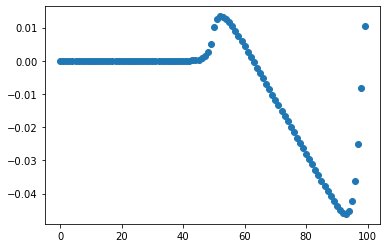

In [9]:
#Plot: Difference of value functions between policy lazy and policy aggressive. 
plt.scatter(list(range(N)),Value_lazy-Value_aggressive)

In [10]:
#Difference in state 50
print('Difference in state=50:' ' '+ str(Value_lazy[50]-Value_aggressive[50]))
#Difference in state 80
print('Difference in state=80:' ' '+ str(Value_lazy[80]-Value_aggressive[80]))

Difference in state=50: 0.010109901063741322
Difference in state=80: -0.02799565826829653


From the previous plot we notice that approximately for the first 50 states, the values of the policies are quite similar. However, when we approach higher states the aggressive policy yields higher values, suggesting that it is a better option. Observe that the results of the difference of the value functions in states 50 and 80 have opposite signs. In the first case, the positive result suggests that the lazy policy is better, while the negative result in state 80 proposes that it is better to follow an aggressive policy.

### Problem 2

#### Value and Policy iteration

In [17]:
# Value Iteration

A = 2

def value_iteration(gamma,V,max_iter):
    
    for k in range(max_iter):
        V_next = -np.inf*np.ones(N)
        Q_estimate = np.zeros((N,A))
        for x in range(N):
            for q,m,n in zip([q_low,q_high],[m_low,m_high],[0,1]):
                Q_estimate[x,n] = reward(q,x) + gamma*m[x,:].dot(V)
                if Q_estimate[x,n] > V_next[x]:
                    V_next[x] = Q_estimate[x,n]
        V = V_next
    return V

In [19]:
# Policy Iteration

A = 2
def policy_iteration(gamma,V,max_iter):

    for k in range(max_iter):
        V_next = -np.inf*np.ones(N)
        Q_estimate = np.zeros((N,A))
        pi_greedy = np.zeros((N,A)) # need to change this for the optimal policy
        
        for x in range(N):
            for q,m,n,pi in zip([q_low,q_high],[m_low,m_high],[0,1],['lazy','aggressive']):
                Q_estimate[x,n] = reward(q,x) + gamma*m[x,:].dot(V)
                if Q_estimate[x,n] > V_next[x]:
                    V_next[x] = Q_estimate[x,n]
                    pi_greedy[x,:] = np.zeros(2) # this is also wrong
                    pi_greedy[x,n] = 1 # this doesn't make sense 

        V = bellman_evaluation(pi,N,gamma,q_low,q_high,matrix_low=m_low,matrix_high=m_high)

    return V

#### Plots

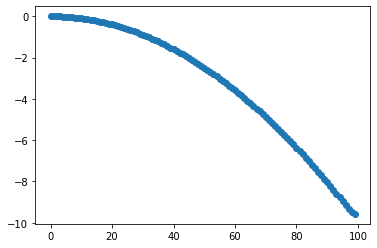

In [20]:
# Value Iteration
value_iteration(gamma,np.zeros(N),100)
plt.scatter(list(range(100)),value_iteration(gamma,np.zeros(N),100))

In [21]:
start_time = timeit.default_timer()
value_iteration(gamma,np.zeros(N),100)
stop_time = timeit.default_timer()
print("The running time of the value iteration is %s seconds" % (stop_time - start_time))

The running time of the value iteration is 0.07624359999999797 seconds


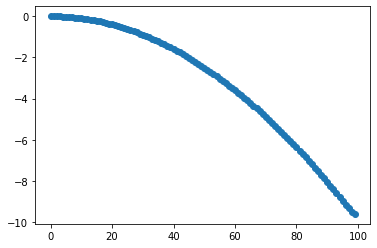

In [22]:
# Policy Iteration
policy_iteration(gamma,np.zeros(N),100)
plt.scatter(list(range(100)),policy_iteration(gamma,np.zeros(N),100))

In [23]:
start_time = timeit.default_timer()
policy_iteration(gamma,np.zeros(N),100)
stop_time = timeit.default_timer()
print("The running time of the policy iteration is %s seconds" % (stop_time - start_time))

The running time of the policy iteration is 0.09694400000012138 seconds


We can see that the policy iteration method takes longer than the value iteration method.

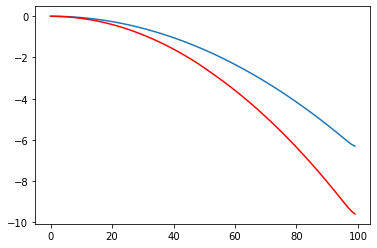

In [24]:
# 10 iterations
fig, ax = plt.subplots()
ax.plot(value_iteration(gamma,np.zeros(N),10))
ax.plot(policy_iteration(gamma,np.zeros(N),10), c = 'red')

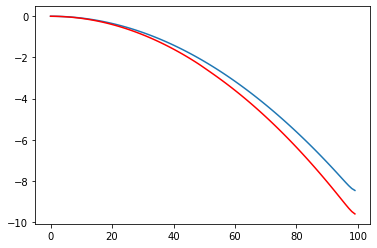

In [25]:
# 20 iterations
fig, ax = plt.subplots()
ax.plot(value_iteration(gamma,np.zeros(N),20))
ax.plot(policy_iteration(gamma,np.zeros(N),20), c = 'red')

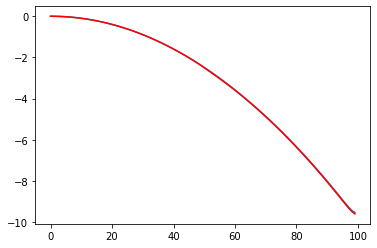

In [26]:
# 50 iterations
fig, ax = plt.subplots()
ax.plot(value_iteration(gamma,np.zeros(N),50))
ax.plot(policy_iteration(gamma,np.zeros(N),50), c = 'red')

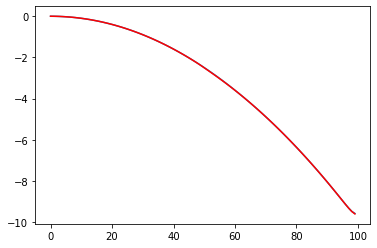

In [27]:
# 100 iterations
fig, ax = plt.subplots()
ax.plot(value_iteration(gamma,np.zeros(N),100))
ax.plot(policy_iteration(gamma,np.zeros(N),100), c = 'red')

From the previous plots we can see that the policy iteration method converges faster than the value iteration method. Furthermore, we notice that for a few number of iterations the convergence path differs between the two methods, and while we increse it, the two curves start to "merge" in to a similar convergence rate.  

#### Optimal value function vs. lazy and aggressive

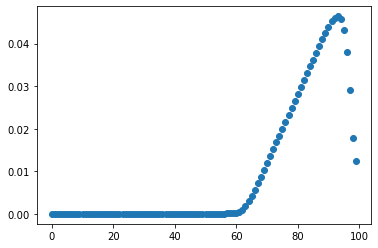

In [28]:
# Optimal vs lazy
plt.scatter(list(range(100)),value_iteration(gamma,np.zeros(N),100)-Value_lazy)

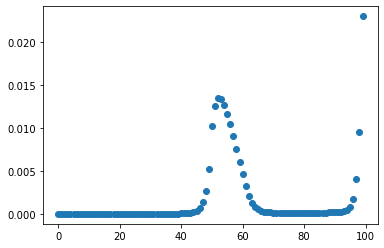

In [29]:
# Optimal vs aggresive
plt.scatter(list(range(100)),value_iteration(gamma,np.zeros(N),100)-Value_aggressive)

The two plots above show that in general, the optimal policy performes better than any of the two policies used in Problem 1. If we look at the graph that depicts the difference $V^* - V^{\pi_{lazy}}$, it is cllear that starting state 60 the value obtained in from the optimal policy is much better than the one obtained by the lazy policy. 

If we now focus on the second graph, we see that the optimal policy outperforms the aggressive policy in two states : between the states 45 and 70 and from the state 90 to the end. Interestingly, the difference between the values is close to zero for states previous to 40.

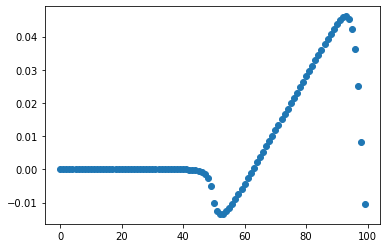

In [33]:
# Optimal vs lazy
plt.scatter(list(range(100)),policy_iteration(gamma,np.zeros(N),100)-Value_lazy)